# Interaction between characters

In [1]:
import sys
sys.path.insert(1, '../src')

from book_entities import *
from book_entities_embeddings_getters import *

## Book entities

In [2]:
# cleaned entities
textually_close_merged_book_cleaned_entities, lax_merged_book_cleaned_entities = get_book_entities(
    f'../data/book_entities/grouped_token_cleaned.csv')

## Paragraphs

In [3]:
from bs4 import BeautifulSoup

In [4]:
# Reading the data inside the xml
# file to a variable under the name
# data
with open('../data/book/stendhal_rougenoir_xml.xml', 'r') as f:
	data = f.read()

In [5]:
# Passing the stored data inside
# the beautifulsoup parser, storing
# the returned object
Bs_data = BeautifulSoup(data, "xml")

In [6]:
paragraphs = []
for tag in Bs_data.find_all('p') :
    if tag.name == 'p' and not ('rend' in tag.attrs) :
        paragraphs.append(tag.get_text())

### dialogue et narration

In [7]:
narration = []
temp_dialogue = []
for p in paragraphs :
    if isinstance(p, str) :
        if p[0] == '–' :
            temp_dialogue.append(p)
        else :
            if len(temp_dialogue)>0 :
                narration.append(' '.join(temp_dialogue))
                temp_dialogue=[]
            narration.append(p)

pour chaque paragraphe chercher si il contient une entité, puis regarder toutes les entités qu'il contient 



In [8]:
len(narration)

3046

### narration

In [9]:
def process_paragraph(p) :
    
    pattern1 = r"""[,.;@#?!&$\s:–]+"""
    pattern2 = r"""[-'’_]"""

    p = re.sub(r'|'.join((pattern1, pattern2)),
               " ",          # and replace it with a single space
               p.replace('\xa0', ' '), flags=re.VERBOSE)
    return [i.lower() for i in p.split(' ')[:-1] if i.lower() not in french_stopwords]

In [10]:
def entity_in_paragraph(entity, paragraph):
    return [1 for address in entity.all_addresses if all(x.lower() in p for x in address.lower().split(' '))]

In [11]:
dict_interaction = {}
new_narration = []
description = []
single_entity_recognized = []
for paragraph in narration :
    p = process_paragraph(paragraph)
    paragraph_entities = [
        i for i in textually_close_merged_book_cleaned_entities if entity_in_paragraph(i, p)]
    
    if len(paragraph_entities)>=2 :
        key = frozenset(paragraph_entities)
        value = dict_interaction.get(key,[])
        value.append(p)
        dict_interaction[key] = value
    else :
        if len(paragraph_entities)>0 :
            single_entity_recognized.append(p)
        else :
            description.append(p)
    new_narration.append(p)

In [12]:
len(dict_interaction)

199

In [13]:
len(description)

942

In [14]:
len(single_entity_recognized)

1228

## DataFrame of Interactions

In [15]:
entities = []
interactions = []
for k, v in dict_interaction.items() :
    entities.append([BookEntity.from_list_entity(ent).get_shortname() for ent in k])
    interactions.append(v)
    
interactions_df = pd.DataFrame({'entities':entities, 'interactions' : interactions})

In [16]:
interactions_df.head()

entities  \
0       [Abbé Julien Sorel, M Rênal]   
1          [Vicaire Maslon, M Rênal]   
2               [Mme Rênal, M Rênal]   
3  [Abbé Chélan, M Valenod, M Rênal]   
4               [M Valenod, M Rênal]   

                                        interactions  
0  [[attendez, point, trouver, france, jardins, p...  
1  [[trouve, chose, reprendre, cours, fidelite, l...  
2  [[jour, automne, m, rênal, promenait, cours, f...  
3  [[faits, commentés, exagérés, façons, agitaien...  
4  [[reproches, m, rênal, m, valenod, directeur, ...

In [17]:
interactions_df['nber_interactions']= interactions_df.interactions.apply(lambda x : len(x))
interactions_df.head()

entities  \
0       [Abbé Julien Sorel, M Rênal]   
1          [Vicaire Maslon, M Rênal]   
2               [Mme Rênal, M Rênal]   
3  [Abbé Chélan, M Valenod, M Rênal]   
4               [M Valenod, M Rênal]   

                                        interactions  nber_interactions  
0  [[attendez, point, trouver, france, jardins, p...                 50  
1  [[trouve, chose, reprendre, cours, fidelite, l...                  1  
2  [[jour, automne, m, rênal, promenait, cours, f...                 12  
3  [[faits, commentés, exagérés, façons, agitaien...                  1  
4  [[reproches, m, rênal, m, valenod, directeur, ...                  8

In [18]:
temp = interactions_df[
    ['entities', 'nber_interactions']].explode('entities')
temp.groupby('entities').aggregate({'nber_interactions':'sum'}).reset_index().sort_values(by = 'nber_interactions', ascending = False)

entities  nber_interactions
2   Abbé Julien Sorel                723
23          Mme Rênal                275
24      Mole Mathilde                210
19            M Rênal                184
10               Dieu                 74
18           M Pirard                 73
21          M Valenod                 73
8          Croisenois                 56
17           M Fouqué                 51
1         Abbé Chélan                 48
30    Vicaire Frilair                 45
22       Mme Derville                 40
7       Comte Norbert                 30
14   Général Napoléon                 26
32              Élisa                 25
5              Caylus                 25
6      Comte Altamira                 22
31     Vicaire Maslon                 19
27    Prince Korasoff                 13
0      Abbé Castanède                 12
3              Amanda                 12
20          M Tanbeau                  9
28       Père Marquis                  9
9              Danton                  8
4           Bonaparte                  8
13           Geronimo                  7
12             Falcoz                  7
11             Estime                  5
25     Mère Stanislas                  3
15           M Appert                  2
16        M Descoulis                  2
26               Pitt                  1
29     Père Stanislas                  1

discard les interactions à plus de 2 personnages

In [19]:
interactions_df['nber_entities'] = interactions_df.entities.apply(lambda x : len(x))
interactions_df= interactions_df[interactions_df['nber_entities'] == 2]
interactions_df.head()

entities  \
0  [Abbé Julien Sorel, M Rênal]   
1     [Vicaire Maslon, M Rênal]   
2          [Mme Rênal, M Rênal]   
4          [M Valenod, M Rênal]   
5               [Dieu, M Rênal]   

                                        interactions  nber_interactions  \
0  [[attendez, point, trouver, france, jardins, p...                 50   
1  [[trouve, chose, reprendre, cours, fidelite, l...                  1   
2  [[jour, automne, m, rênal, promenait, cours, f...                 12   
4  [[reproches, m, rênal, m, valenod, directeur, ...                  8   
5  [[, enlever, approuves, projet, m, rênal, reme...                  2   

   nber_entities  
0              2  
1              2  
2              2  
4              2  
5              2

In [20]:
interactions_df['index_interactions'] = interactions_df.interactions.apply(
    lambda x :[new_narration.index(inter) for inter in x])

In [21]:
interactions_df = interactions_df.sort_values(by = 'nber_interactions', ascending = False)

In [22]:
interactions_df.head()

entities  \
16       [Mme Rênal, Abbé Julien Sorel]   
107  [Mole Mathilde, Abbé Julien Sorel]   
0          [Abbé Julien Sorel, M Rênal]   
77        [M Pirard, Abbé Julien Sorel]   
8             [Dieu, Abbé Julien Sorel]   

                                          interactions  nber_interactions  \
16   [[julien, cœur, troublé, arrivée, maison, extr...                121   
107  [[lendemain, fort, bonne, heure, julien, faisa...                103   
0    [[attendez, point, trouver, france, jardins, p...                 50   
77   [[julien, releva, yeux, effort, voix, battemen...                 39   
8    [[«, descends, animal, », bruit, machine, empê...                 28   

     nber_entities                                 index_interactions  
16               2  [104, 109, 111, 115, 117, 119, 123, 125, 127, ...  
107              2  [1366, 1373, 1375, 1413, 1586, 1593, 1614, 163...  
0                2  [8, 9, 11, 39, 48, 49, 65, 70, 72, 75, 94, 102...  
77               2  [907, 927, 934, 936, 942, 948, 955, 964, 1008,...  
8                2  [56, 95, 303, 456, 573, 595, 622, 678, 904, 92...

### embeddings of interactions

In [23]:
model_name = 'flaubert/flaubert_base_cased' 

# Load pretrained model and tokenizer
flaubert, log = FlaubertModel.from_pretrained(model_name, output_loading_info=True)
flaubert_tokenizer = FlaubertTokenizer.from_pretrained(model_name, do_lowercase=False)

def from_interaction_to_embeddings (list_interactions) :
    embeddings = []
    for interaction in list_interactions :
        token_ids = torch.tensor([flaubert_tokenizer.encode(interaction)])
        last_layer = flaubert(token_ids)[0][:,1:-1, :]

        # possibilité de faire d'autres opérations
        # embeddings.append(torch.mean(last_layer, dim = 1).detach().numpy()[0])
        embeddings.append(last_layer.detach().numpy())
    return embeddings

interactions_df['embeddings'] = interactions_df.interactions.apply(
    lambda x : from_interaction_to_embeddings(x))
                                                             

Some weights of the model checkpoint at flaubert/flaubert_base_cased were not used when initializing FlaubertModel: ['pred_layer.proj.bias', 'pred_layer.proj.weight']
- This IS expected if you are initializing FlaubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing FlaubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
renal_sorel = interactions_df.iloc[0].embeddings

In [25]:
interactions_df.entities.head()

16         [Mme Rênal, Abbé Julien Sorel]
107    [Mole Mathilde, Abbé Julien Sorel]
0            [Abbé Julien Sorel, M Rênal]
77          [M Pirard, Abbé Julien Sorel]
8               [Dieu, Abbé Julien Sorel]
Name: entities, dtype: object

In [26]:
mole_sorel = interactions_df.iloc[1].embeddings

In [27]:
renal_m_sorel = interactions_df.iloc[2].embeddings

In [28]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category =UserWarning)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 

In [38]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

## PCA

In [116]:
renal_sorel_pca = []
for emb in tqdm(renal_sorel) :
    pca = PCA(n_components=3, svd_solver = 'arpack')
    temp = pd.DataFrame(emb[0])
    components = pca.fit_transform(temp)
    renal_sorel_pca.append(components)

100%|███████████████████████████████████████████████████████████| 121/121 [00:05<00:00, 22.56it/s]


In [117]:
mole_sorel_pca = []
for emb in tqdm(mole_sorel) :
    pca = PCA(n_components=3, svd_solver = 'arpack')
    temp = pd.DataFrame(emb[0])
    components = pca.fit_transform(temp)
    mole_sorel_pca.append(components)

100%|███████████████████████████████████████████████████████████| 103/103 [00:05<00:00, 19.19it/s]


In [34]:
renal_m_sorel_pca = []
for emb in tqdm(renal_m_sorel) :
    pca = PCA(n_components=2, svd_solver = 'arpack')
    temp = pd.DataFrame(emb[0])
    components = pca.fit_transform(temp)
    renal_m_sorel_pca.append(components)

100%|█████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 50.36it/s]


In [97]:
mole_sorel_df.head()

0             1
0 -5.263787e-07  4.892225e-07
1 -2.980232e-07  3.278255e-07
2 -4.238553e-07 -2.715323e-07
3 -1.816523e-07  1.816523e-07
4 -1.121970e-07 -5.609849e-08

In [108]:
mole_sorel_pca[0]

array([[-5.7035604e+00, -2.6815574e+00],
       [-5.1077213e+00, -3.1702650e+00],
       [-5.3721080e+00, -2.9206555e+00],
       [-5.7305751e+00, -2.6749635e+00],
       [-5.4900918e+00, -2.5976541e+00],
       [-5.4621964e+00, -2.6908817e+00],
       [-5.2832065e+00, -2.4880257e+00],
       [-5.2035766e+00, -2.2855031e+00],
       [-5.1420560e+00, -1.9845576e+00],
       [-4.9168921e+00, -1.6150856e+00],
       [-4.5928893e+00, -1.4238958e+00],
       [-4.3659511e+00, -1.3756260e+00],
       [-4.1032438e+00, -1.1833842e+00],
       [-3.0970695e+00, -1.9233679e+00],
       [-3.1004937e+00, -1.4320484e+00],
       [-2.6388314e+00, -1.1271737e+00],
       [-2.8111041e+00, -8.7119204e-01],
       [-3.0832782e+00, -5.1258588e-01],
       [-3.0797012e+00, -3.8966334e-01],
       [-3.1100266e+00, -1.3671198e-01],
       [-3.2796898e+00, -1.6190649e-03],
       [-3.3729260e+00,  6.2180705e-02],
       [-3.2837505e+00,  4.9202412e-02],
       [-3.1997020e+00,  1.5526922e-01],
       [-2.63363

In [109]:
np.mean(mole_sorel_pca[0], axis = 0)

array([-5.2637870e-07,  4.8922254e-07], dtype=float32)

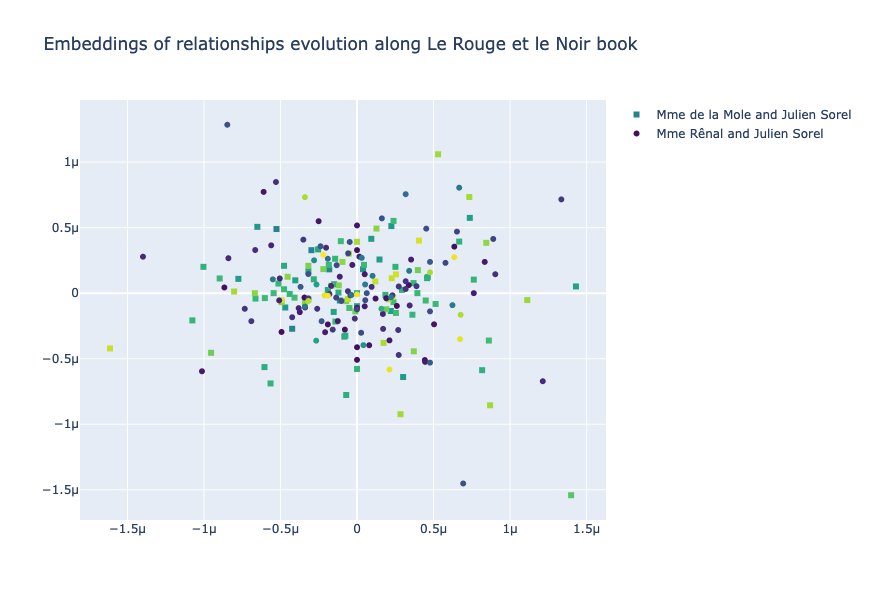

In [114]:
fig = make_subplots(rows=1, cols=1, column_widths= [2000], row_heights=[800])

mole_sorel_df = pd.DataFrame([np.mean(x, axis = 0) for x in mole_sorel_pca])
renal_sorel_df = pd.DataFrame([np.mean(x, axis = 0) for x in renal_sorel_pca])

fig.add_trace(
    go.Scatter(x = mole_sorel_df[0], y = mole_sorel_df[1], mode='markers', marker = dict (
        color=interactions_df.iloc[1].index_interactions, colorscale = 'viridis', symbol = 'square', cmax = len(narration), cmin = 0),
               name = "Mme de la Mole and Julien Sorel"), row = 1, col = 1)

fig.add_trace(
    go.Scatter(x = renal_sorel_df[0], y = renal_sorel_df[1], mode='markers', marker = dict (
        color=interactions_df.iloc[0].index_interactions, colorscale = 'viridis', cmax = len(narration), cmin = 0),
               name = 'Mme Rênal and Julien Sorel'), row = 1, col = 1)

fig.update_layout(height=600, width=1000, title_text="Embeddings of relationships evolution along Le Rouge et le Noir book")
fig.show()

inverted color scale :
- the more yellow the more close to begginning
- the more purple the more close to the end

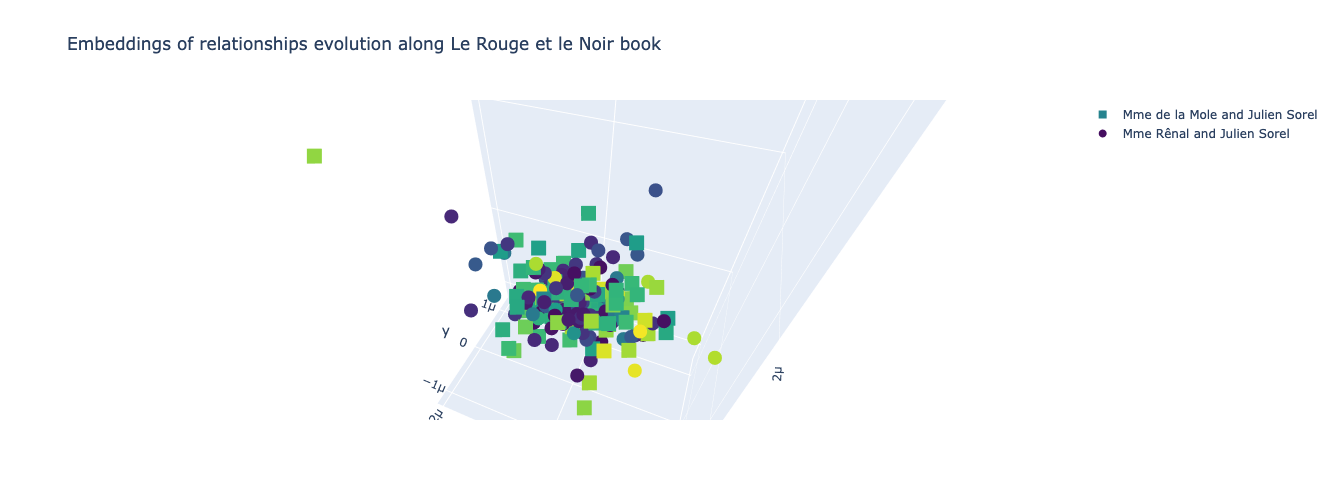

In [122]:
# 3D
fig = make_subplots(rows=1, cols=1, column_widths= [1000], row_heights=[800],
                    specs=[[{'type': 'surface'}]])

mole_sorel_df = pd.DataFrame([np.mean(x, axis = 0) for x in mole_sorel_pca])
renal_sorel_df = pd.DataFrame([np.mean(x, axis = 0) for x in renal_sorel_pca])

fig.add_trace(
    go.Scatter3d(x = mole_sorel_df[0], y = mole_sorel_df[1],z=mole_sorel_df[2], mode='markers', marker = dict (
        color=interactions_df.iloc[1].index_interactions, colorscale = 'viridis', symbol = 'square', cmax = len(narration), cmin = 0),
               name = "Mme de la Mole and Julien Sorel"), row = 1, col = 1)

fig.add_trace(
    go.Scatter3d(x = renal_sorel_df[0], y = renal_sorel_df[1], z=renal_sorel_df[2], mode='markers', marker = dict (
        color=interactions_df.iloc[0].index_interactions, colorscale = 'viridis', cmax = len(narration), cmin = 0),
               name = 'Mme Rênal and Julien Sorel'), row = 1, col = 1)

fig.update_layout(height=500, width=1000, title_text="Embeddings of relationships evolution along Le Rouge et le Noir book")
fig.show()

prendre comme couleur pas l'index du paragraphe

partait de 2048 => 256, PCA!! ou tsne

puis 256 => 2 ou 3 dim, u-map ou tsne

768 => 512 => 256 
TODO : PCA puis tsne

## PCA and TSNE

In [36]:
renal_sorel_pca_tsne = []
for emb in tqdm(renal_sorel) :
    pca = PCA(n_components=4, svd_solver = 'arpack')
    tsne = TSNE(n_components=2,learning_rate='auto', init='pca')
    temp = pd.DataFrame(emb[0])
    components = tsne.fit_transform(pca.fit_transform(temp))
    renal_sorel_pca_tsne.append(components)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [1:32:25<00:00, 45.83s/it]


In [30]:
mole_sorel_pca_tsne = []

for emb in tqdm(mole_sorel) :
    pca = PCA(n_components=4, svd_solver = 'arpack')
    tsne = TSNE(n_components=2,learning_rate='auto', init='pca')
    temp = pd.DataFrame(emb[0])
    components = tsne.fit_transform(pca.fit_transform(temp))
    mole_sorel_pca_tsne.append(components)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 103/103 [40:41<00:00, 23.71s/it]


In [31]:
mole_sorel_df = pd.DataFrame([np.mean(x, axis = 0) for x in mole_sorel_pca_tsne])
renal_sorel_df = pd.DataFrame([np.mean(x, axis = 0) for x in renal_sorel_pca_tsne])

mole_sorel_df ['index_inter'] = interactions_df.iloc[1].index_interactions
renal_sorel_df['index_inter'] = interactions_df.iloc[0].index_interactions

mole_sorel_df.columns=['component 0', 'component 1', 'index_inter']
renal_sorel_df.columns=['component 0', 'component 1', 'index_inter']

mole_sorel_df.to_csv('../data/dim_reduc/mole_sorel_df_pca_tsne.csv')
renal_sorel_df.to_csv('../data/dim_reduc/renal_sorel_df_pca_tsne.csv')

In [16]:
mole_sorel_df = pd.read_csv('mole_sorel_df.csv')[['component 0', 'component 1', 'index_inter']] 
renal_sorel_df = pd.read_csv('renal_sorel_df.csv')[['component 0', 'component 1', 'index_inter']] 

In [17]:
mole_sorel_df.head()

component 0  component 1  index_inter
0     0.533238     1.566389         1366
1     5.764099    -7.229536         1373
2    -9.008648   -12.359603         1375
3    -7.478396   -12.507272         1413
4   -19.350412     4.218814         1586

In [18]:
renal_sorel_df.head()

component 0  component 1  index_inter
0    -3.294510    -0.669342          104
1    26.257820    -1.786927          109
2     4.310876    -3.658034          111
3    -7.554264   -22.274527          115
4    -2.544290     3.711381          117

## Umap

In [51]:
from umap import UMAP

In [67]:
renal_sorel_umap = []
for emb in tqdm(renal_sorel) :
    # pca = PCA(n_components=4, svd_solver = 'arpack')
    umap = UMAP()
    temp = pd.DataFrame(emb[0])
    components = umap.fit_transform(temp)
    # components = tsne.fit_transform(pca.fit_transform(temp))
    renal_sorel_umap.append(components)

  2%|██▌                                                                                                     | 3/121 [00:21<13:51,  7.04s/it]/scratch/students/doyard/lib/python3.8/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
  5%|█████▏                                                                                                  | 6/121 [00:44<14:25,  7.52s/it]/scratch/students/doyard/lib/python3.8/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
 12%|████████████▊                                                                                          | 15/121 [01:51<13:12,  7.47s/it]/scratch/students/doyard/lib/python3.8/site-packages/umap/umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
 14%|██████████████▍                                                     

In [68]:
# mole_sorel_df = pd.DataFrame([np.mean(x, axis = 0) for x in mole_sorel_pca_tsne])
renal_sorel_df = pd.DataFrame([np.mean(x, axis = 0) for x in renal_sorel_umap])

# mole_sorel_df ['index_inter'] = interactions_df.iloc[1].index_interactions
renal_sorel_df['index_inter'] = interactions_df.iloc[0].index_interactions

# mole_sorel_df.columns=['component 0', 'component 1', 'index_inter']
renal_sorel_df.columns=['component 0', 'component 1', 'index_inter']

#mole_sorel_df.to_csv('mole_sorel_df_full_tsne.csv')
renal_sorel_df.to_csv('renal_sorel_umap.csv')

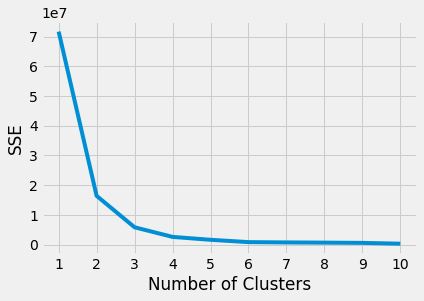

In [71]:
from sklearn.cluster import KMeans    
import matplotlib.pyplot as plt

kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(renal_sorel_df)
    sse.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [72]:
from kneed import KneeLocator
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

3

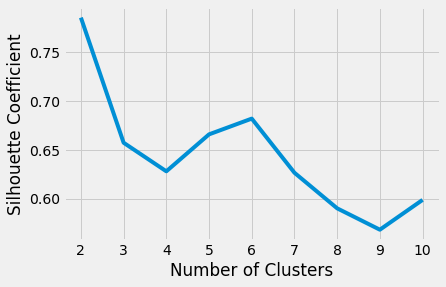

In [73]:
from sklearn.metrics import silhouette_score

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(renal_sorel_df)
    score = silhouette_score(renal_sorel_df, kmeans.labels_)
    silhouette_coefficients.append(score)
    
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [74]:
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans.fit(renal_sorel_df)
renal_sorel_df['cluster'] = kmeans.labels_

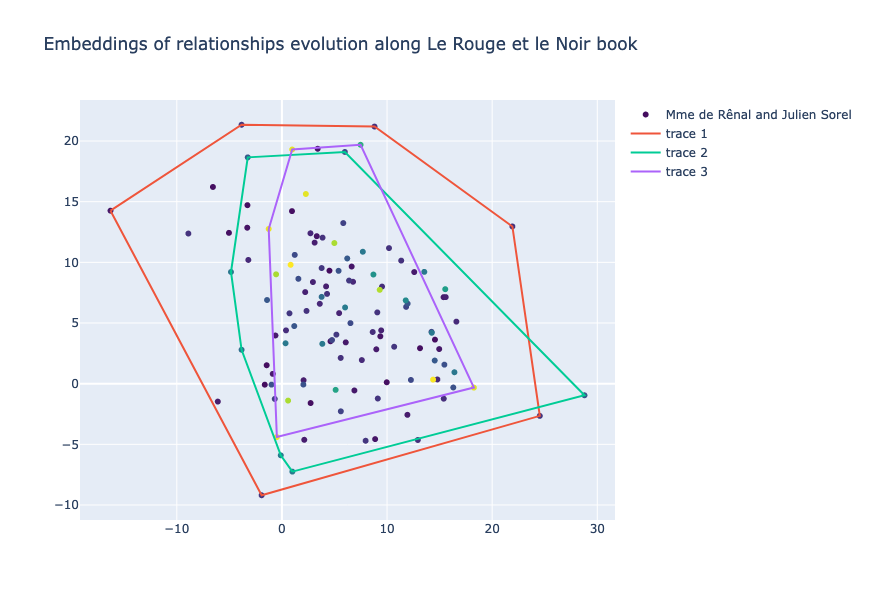

In [76]:
from scipy.spatial import ConvexHull

fig = make_subplots(rows=1, cols=1, column_widths= [2000], row_heights=[800])


# plot renal sorel data
fig.add_trace(
    go.Scatter(x = renal_sorel_df['component 0'], y = renal_sorel_df['component 1'], mode='markers', marker = dict (
        color=renal_sorel_df.index_inter, colorscale = 'viridis', cmax = len(narration), cmin = 0),
               name = "Mme de Rênal and Julien Sorel", hovertext = renal_sorel_df['index_inter']), row = 1, col = 1)

# plot renal sorel convex hulls
for i in renal_sorel_df.cluster.unique():
    points = renal_sorel_df[renal_sorel_df.cluster == i][['component 0', 'component 1']].values
    # get convex hull
    hull = ConvexHull(points)
    # get x and y coordinates
    # repeat last point to close the polygon
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])
    # plot shape
    fig.add_trace(
        go.Scatter(x = x_hull, y= y_hull, mode = 'lines'))

fig.update_layout(height=600, width=1000, title_text="Embeddings of relationships evolution along Le Rouge et le Noir book")

fig.show()

## TSNE

In [ ]:
renal_sorel_pca_tsne = []
for emb in tqdm(renal_sorel) :
    tsne = TSNE(n_components=2,learning_rate='auto', init='random')
    temp = pd.DataFrame(emb[0])
    components = tsne.fit_transform(temp)
    renal_sorel_pca_tsne.append(components)

## Clustering

### For Mme de Rênal and Julien Sorel

In [19]:
from sklearn.cluster import KMeans
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(renal_sorel_df)
    sse.append(kmeans.inertia_)

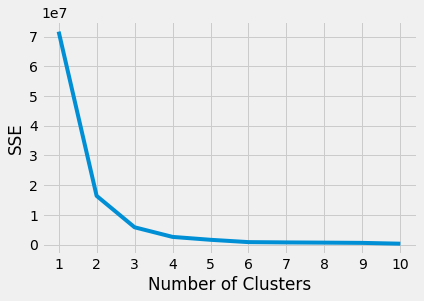

In [20]:
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()


!pip install kneed

In [21]:
from kneed import KneeLocator
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow

3

In [22]:
from sklearn.metrics import silhouette_score

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(renal_sorel_df)
    score = silhouette_score(renal_sorel_df, kmeans.labels_)
    silhouette_coefficients.append(score)

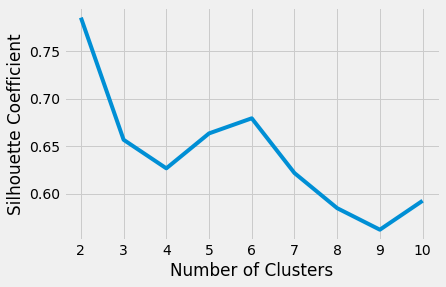

In [23]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [24]:
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans.fit(renal_sorel_df)

KMeans(init='random', n_clusters=3, random_state=42)

In [25]:
renal_sorel_df['cluster'] = kmeans.labels_

In [26]:
renal_sorel_df.head()

component 0  component 1  index_inter  cluster
0    -3.294510    -0.669342          104        2
1    26.257820    -1.786927          109        2
2     4.310876    -3.658034          111        2
3    -7.554264   -22.274527          115        2
4    -2.544290     3.711381          117        2

In [27]:
renal_sorel_inter_per_cluster = renal_sorel_df.groupby(
    'cluster').aggregate({ 'index_inter' : list, 'component 0' : 'count'}).reset_index()

In [28]:
renal_sorel_inter_per_cluster.head()

cluster                                        index_inter  component 0
0        0  [682, 695, 698, 711, 729, 753, 760, 764, 778, ...           33
1        1  [1929, 2650, 2660, 2661, 2695, 2911, 2924, 293...           12
2        2  [104, 109, 111, 115, 117, 119, 123, 125, 127, ...           76

In [80]:
def get_text_interactions(list_interactions) :
    text_interactions = []
    for i in list_interactions :
        text_interactions.append(narration[i])
    return text_interactions

In [81]:
renal_sorel_inter_per_cluster[
    'text_interaction'] = renal_sorel_inter_per_cluster.index_inter.apply(lambda x : get_text_interactions(x))
                                                                          

In [66]:
renal_sorel_inter_per_cluster.head()

cluster                                        index_inter  component 0  \
0        0  [682, 695, 698, 711, 729, 753, 760, 764, 778, ...           33   
1        1  [1929, 2650, 2660, 2661, 2695, 2911, 2924, 293...           12   
2        2  [104, 109, 111, 115, 117, 119, 123, 125, 127, ...           76   

                                    text_interaction  
0  [Elle revenait du village. Elle était allée en...  
1  [Ce n’était pas, il est vrai, cette volupté de...  
2  [Julien n’était pas la seule personne dont le ...

In [49]:
for i in renal_sorel_inter_per_cluster[renal_sorel_inter_per_cluster.cluster == 0].text_interaction.iloc[0] :
    print(i)

Elle revenait du village. Elle était allée entendre la messe dans l’église de Vergy. Une tradition fort incertaine aux yeux du froid philosophe, mais à laquelle elle ajoutait foi, prétend que la petite église dont on se sert aujourd’hui était la chapelle du château du sire de Vergy. Cette idée obséda Mme de Rênal tout le temps qu’elle comptait passer à prier dans cette église. Elle se figurait sans cesse son mari tuant Julien à la chasse, comme par accident, et ensuite le soir lui faisant manger son cœur.
Mme de Rênal eut un sang-froid inaltérable pendant toute cette pénible conversation, de laquelle dépendait la possibilité de vivre encore sous le même toit avec Julien. Elle cherchait les idées qu’elle croyait les plus propres à guider la colère aveugle de son mari. Elle avait été insensible à toutes les réflexions injurieuses qu’il lui avait adressées, elle ne les écoutait pas, elle songeait alors à Julien. Sera-t-il content de moi ?
Mme de Rênal avait monté en courant les cent vingt

In [132]:
for i in renal_sorel_inter_per_cluster[renal_sorel_inter_per_cluster.cluster == 1].text_interaction.iloc[0] :
    print(i)

Ce n’était pas, il est vrai, cette volupté de l’âme qu’il avait trouvée quelquefois auprès de Mme de Rênal. Il n’y avait rien de tendre dans ses sentiments de ce premier moment. C’était le plus vif bonheur d’ambition, et Julien était surtout ambitieux. Il parla de nouveau des gens par lui soupçonnés, et des précautions qu’il avait inventées. En parlant il songeait aux moyens de profiter de sa victoire.
– Où est la lettre de Mme de Rênal ? dit froidement Julien. – La voici. Je n’ai voulu te la montrer qu’après que tu aurais été préparé.
Julien entra dans l’église neuve de Verrières. Toutes les fenêtres hautes de l’édifice étaient voilées avec des rideaux cramoisis. Julien se trouva à quelques pas derrière le banc de Mme de Rênal. Il lui sembla qu’elle priait avec ferveur. La vue de cette femme qui l’avait tant aimé fit trembler le bras de Julien d’une telle façon, qu’il ne put d’abord exécuter son dessein. Je ne le puis, se disait-il à lui-même ; physiquement, je ne le puis.
En ce momen

In [133]:
for i in renal_sorel_inter_per_cluster[renal_sorel_inter_per_cluster.cluster == 2].text_interaction.iloc[0] :
    print(i)

Julien n’était pas la seule personne dont le cœur fût troublé par son arrivée dans cette maison. L’extrême timidité de Mme de Rênal était déconcertée par l’idée de cet étranger, qui, d’après ses fonctions, allait constamment se trouver entre elle et ses enfants. Elle était accoutumée à avoir ses fils couchés dans sa chambre. Le matin, bien des larmes avaient coulé quand elle avait vu transporter leurs petits lits dans l’appartement destiné au précepteur. Ce fut en vain qu’elle demanda à son mari que le lit de Stanislas-Xavier, le plus jeune, fût reporté dans sa chambre.
Julien se tourna vivement, et, frappé du regard si rempli de grâce de Mme de Rênal, il oublia une partie de sa timidité. Bientôt, étonné de sa beauté, il oublia tout même ce qu’il venait faire. Mme de Rênal avait répété sa question.
Mme de Rênal resta interdite, ils étaient fort près l’un de l’autre à se regarder. Julien n’avait jamais vu un être aussi bien vêtu et surtout une femme avec un teint si éblouissant, lui par

### For Mlle Mathilde de la Mole and Julien Sorel

In [29]:
from sklearn.cluster import KMeans
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(mole_sorel_df)
    sse.append(kmeans.inertia_)

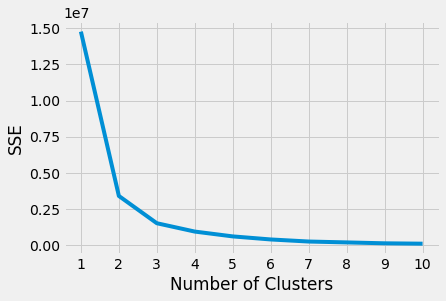

In [30]:
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()


In [31]:
from kneed import KneeLocator
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow


3

In [32]:
from sklearn.metrics import silhouette_score

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(mole_sorel_df)
    score = silhouette_score(mole_sorel_df, kmeans.labels_)
    silhouette_coefficients.append(score)

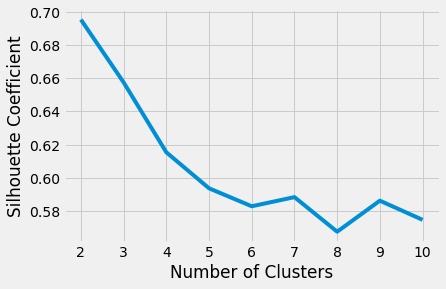

In [33]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [34]:
kmeans = KMeans(n_clusters=3, **kmeans_kwargs)
kmeans.fit(mole_sorel_df)

KMeans(init='random', n_clusters=3, random_state=42)

In [35]:
mole_sorel_df['cluster'] = kmeans.labels_

In [36]:
mole_sorel_df.head()

component 0  component 1  index_inter  cluster
0     0.533238     1.566389         1366        0
1     5.764099    -7.229536         1373        0
2    -9.008648   -12.359603         1375        0
3    -7.478396   -12.507272         1413        0
4   -19.350412     4.218814         1586        0

### Plotting the convex hulls

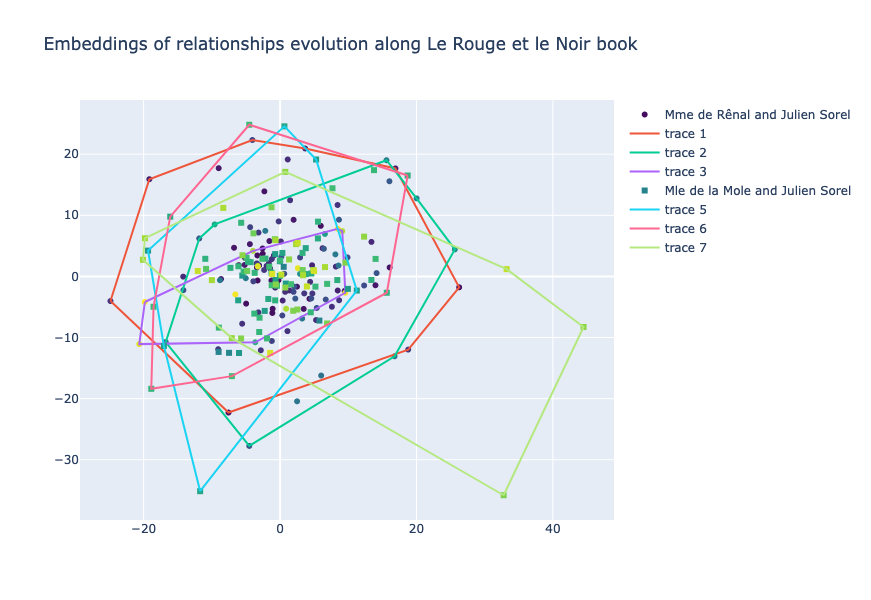

In [42]:
from scipy.spatial import ConvexHull

fig = make_subplots(rows=1, cols=1, column_widths= [2000], row_heights=[800])


# plot renal sorel data
fig.add_trace(
    go.Scatter(x = renal_sorel_df['component 0'], y = renal_sorel_df['component 1'], mode='markers', marker = dict (
        color=renal_sorel_df.index_inter, colorscale = 'viridis', cmax = len(narration), cmin = 0),
               name = "Mme de Rênal and Julien Sorel"), row = 1, col = 1)
    
# plot renal sorel convex hulls
for i in renal_sorel_df.cluster.unique():
    points = renal_sorel_df[renal_sorel_df.cluster == i][['component 0', 'component 1']].values
    # get convex hull
    hull = ConvexHull(points)
    # get x and y coordinates
    # repeat last point to close the polygon
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])
    # plot shape
    fig.add_trace(
        go.Scatter(x = x_hull, y= y_hull, mode = 'lines'))

# plot mole sorel data
fig.add_trace(
    go.Scatter(x = mole_sorel_df['component 0'], y = mole_sorel_df['component 1'], mode='markers', marker = dict (
        color=mole_sorel_df.index_inter, colorscale = 'viridis', symbol = 'square', cmax = len(narration), cmin = 0),
               name = "Mle de la Mole and Julien Sorel"), row = 1, col = 1)
    
# plot mole sorel convex hulls
for i in mole_sorel_df.cluster.unique():
    points = mole_sorel_df[mole_sorel_df.cluster == i][['component 0', 'component 1']].values
    # get convex hull
    hull = ConvexHull(points)
    # get x and y coordinates
    # repeat last point to close the polygon
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])
    # plot shape
    fig.add_trace(
        go.Scatter(x = x_hull, y= y_hull, mode = 'lines'))
    
fig.update_layout(height=600, width=1000, title_text="Embeddings of relationships evolution along Le Rouge et le Noir book")

fig.show()

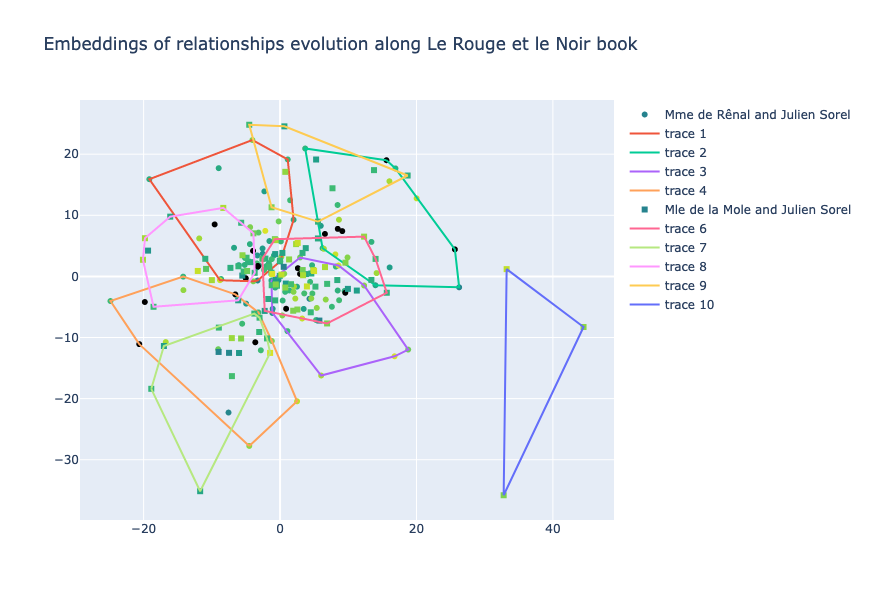

In [122]:
from scipy.spatial import ConvexHull

fig = make_subplots(rows=1, cols=1, column_widths= [2000], row_heights=[800])


# plot renal sorel data
fig.add_trace(
    go.Scatter(x = renal_sorel_df[0], y = renal_sorel_df[1], mode='markers', marker = dict (
        color=interactions_df.iloc[1].index_interactions, colorscale = 'viridis', cmax = len(narration), cmin = 0),
               name = "Mme de Rênal and Julien Sorel"), row = 1, col = 1)
    
# plot renal sorel convex hulls
for i in renal_sorel_df.cluster.unique():
    points = renal_sorel_df[renal_sorel_df.cluster == i][[0, 1]].values
    # get convex hull
    hull = ConvexHull(points)
    # get x and y coordinates
    # repeat last point to close the polygon
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])
    # plot shape
    fig.add_trace(
        go.Scatter(x = x_hull, y= y_hull, mode = 'lines'))

# plot mole sorel data
fig.add_trace(
    go.Scatter(x = mole_sorel_df[0], y = mole_sorel_df[1], mode='markers', marker = dict (
        color=interactions_df.iloc[1].index_interactions, colorscale = 'viridis', symbol = 'square', cmax = len(narration), cmin = 0),
               name = "Mle de la Mole and Julien Sorel"), row = 1, col = 1)
    
# plot mole sorel convex hulls
for i in mole_sorel_df.cluster.unique():
    points = mole_sorel_df[mole_sorel_df.cluster == i][[0, 1]].values
    # get convex hull
    hull = ConvexHull(points)
    # get x and y coordinates
    # repeat last point to close the polygon
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])
    # plot shape
    fig.add_trace(
        go.Scatter(x = x_hull, y= y_hull, mode = 'lines'))
    
fig.update_layout(height=600, width=1000, title_text="Embeddings of relationships evolution along Le Rouge et le Noir book")

fig.show()

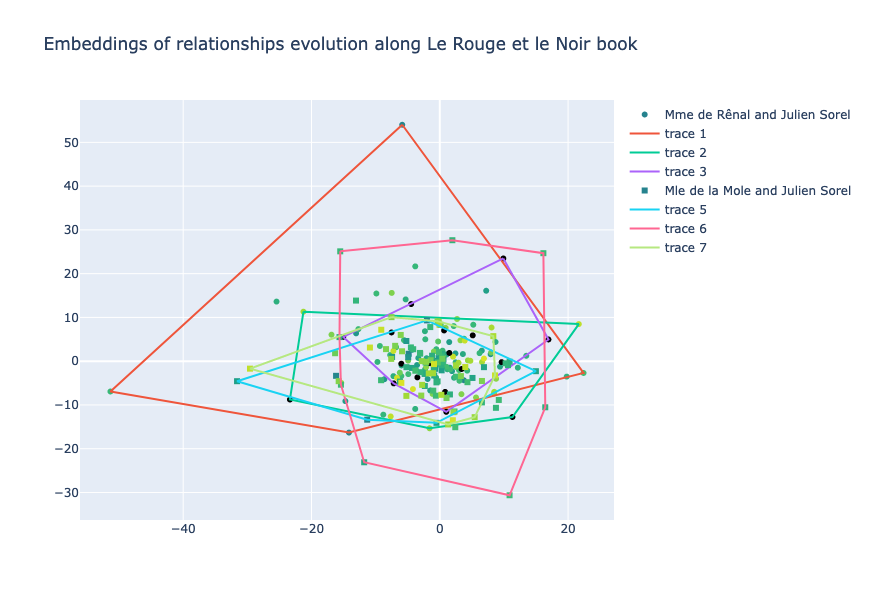

In [65]:
from scipy.spatial import ConvexHull

fig = make_subplots(rows=1, cols=1, column_widths= [2000], row_heights=[800])


# plot renal sorel data
fig.add_trace(
    go.Scatter(x = renal_sorel_df['component 0'], y = renal_sorel_df['component 1'], mode='markers', marker = dict (
        color=interactions_df.iloc[1].index_interactions, colorscale = 'viridis', cmax = len(narration), cmin = 0),
               name = "Mme de Rênal and Julien Sorel"), row = 1, col = 1)
    
# plot renal sorel convex hulls
for i in renal_sorel_df.cluster.unique():
    points = renal_sorel_df[renal_sorel_df.cluster == i][['component 0', 'component 1']].values
    # get convex hull
    hull = ConvexHull(points)
    # get x and y coordinates
    # repeat last point to close the polygon
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])
    # plot shape
    fig.add_trace(
        go.Scatter(x = x_hull, y= y_hull, mode = 'lines'))

# plot mole sorel data
fig.add_trace(
    go.Scatter(x = mole_sorel_df['component 0'], y = mole_sorel_df['component 1'], mode='markers', marker = dict (
        color=interactions_df.iloc[1].index_interactions, colorscale = 'viridis', symbol = 'square', cmax = len(narration), cmin = 0),
               name = "Mle de la Mole and Julien Sorel"), row = 1, col = 1)
    
# plot mole sorel convex hulls
for i in mole_sorel_df.cluster.unique():
    points = mole_sorel_df[mole_sorel_df.cluster == i][['component 0', 'component 1']].values
    # get convex hull
    hull = ConvexHull(points)
    # get x and y coordinates
    # repeat last point to close the polygon
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])
    # plot shape
    fig.add_trace(
        go.Scatter(x = x_hull, y= y_hull, mode = 'lines'))
    
fig.update_layout(height=600, width=1000, title_text="Embeddings of relationships evolution along Le Rouge et le Noir book")

fig.show()

3D : utiliser colonne numero interaction pour 3e dimension

tester tsne de 768 à 2 dims
tester PCA avec randomized


## Test

In [40]:
frames = [go.Scatter(x=mole_sorel_df[mole_sorel_df['index_inter'] == i]['component 0'],
            y=mole_sorel_df[mole_sorel_df['index_inter'] == i]['component 1'],
             mode='markers', marker = dict (
        color=mole_sorel_df[mole_sorel_df['index_inter'] == i]['index_inter'], colorscale = 'viridis', symbol = 'square',
                 cmax = len(narration), cmin = 0),
               name = "Mme de la Mole and Julien Sorel")
          for i in range(len(narration))]

fig.update(frames=frames)

ValueError: 
    Invalid element(s) received for the 'frames' property of 
        Invalid elements include: [Scatter({
    'marker': {'cmax': 3046,
               'cmin': 0,
               'color': array([], dtype=int64),
               'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
                              [0.2222222222222222, '#3e4989'], [0.3333333333333333,
                              '#31688e'], [0.4444444444444444, '#26828e'],
                              [0.5555555555555556, '#1f9e89'], [0.6666666666666666,
                              '#35b779'], [0.7777777777777778, '#6ece58'],
                              [0.8888888888888888, '#b5de2b'], [1.0, '#fde725']],
               'symbol': 'square'},
    'mode': 'markers',
    'name': 'Mme de la Mole and Julien Sorel',
    'x': array([], dtype=float64),
    'y': array([], dtype=float64)
}), Scatter({
    'marker': {'cmax': 3046,
               'cmin': 0,
               'color': array([], dtype=int64),
               'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
                              [0.2222222222222222, '#3e4989'], [0.3333333333333333,
                              '#31688e'], [0.4444444444444444, '#26828e'],
                              [0.5555555555555556, '#1f9e89'], [0.6666666666666666,
                              '#35b779'], [0.7777777777777778, '#6ece58'],
                              [0.8888888888888888, '#b5de2b'], [1.0, '#fde725']],
               'symbol': 'square'},
    'mode': 'markers',
    'name': 'Mme de la Mole and Julien Sorel',
    'x': array([], dtype=float64),
    'y': array([], dtype=float64)
}), Scatter({
    'marker': {'cmax': 3046,
               'cmin': 0,
               'color': array([], dtype=int64),
               'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
                              [0.2222222222222222, '#3e4989'], [0.3333333333333333,
                              '#31688e'], [0.4444444444444444, '#26828e'],
                              [0.5555555555555556, '#1f9e89'], [0.6666666666666666,
                              '#35b779'], [0.7777777777777778, '#6ece58'],
                              [0.8888888888888888, '#b5de2b'], [1.0, '#fde725']],
               'symbol': 'square'},
    'mode': 'markers',
    'name': 'Mme de la Mole and Julien Sorel',
    'x': array([], dtype=float64),
    'y': array([], dtype=float64)
}), Scatter({
    'marker': {'cmax': 3046,
               'cmin': 0,
               'color': array([], dtype=int64),
               'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
                              [0.2222222222222222, '#3e4989'], [0.3333333333333333,
                              '#31688e'], [0.4444444444444444, '#26828e'],
                              [0.5555555555555556, '#1f9e89'], [0.6666666666666666,
                              '#35b779'], [0.7777777777777778, '#6ece58'],
                              [0.8888888888888888, '#b5de2b'], [1.0, '#fde725']],
               'symbol': 'square'},
    'mode': 'markers',
    'name': 'Mme de la Mole and Julien Sorel',
    'x': array([], dtype=float64),
    'y': array([], dtype=float64)
}), Scatter({
    'marker': {'cmax': 3046,
               'cmin': 0,
               'color': array([], dtype=int64),
               'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
                              [0.2222222222222222, '#3e4989'], [0.3333333333333333,
                              '#31688e'], [0.4444444444444444, '#26828e'],
                              [0.5555555555555556, '#1f9e89'], [0.6666666666666666,
                              '#35b779'], [0.7777777777777778, '#6ece58'],
                              [0.8888888888888888, '#b5de2b'], [1.0, '#fde725']],
               'symbol': 'square'},
    'mode': 'markers',
    'name': 'Mme de la Mole and Julien Sorel',
    'x': array([], dtype=float64),
    'y': array([], dtype=float64)
}), Scatter({
    'marker': {'cmax': 3046,
               'cmin': 0,
               'color': array([], dtype=int64),
               'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
                              [0.2222222222222222, '#3e4989'], [0.3333333333333333,
                              '#31688e'], [0.4444444444444444, '#26828e'],
                              [0.5555555555555556, '#1f9e89'], [0.6666666666666666,
                              '#35b779'], [0.7777777777777778, '#6ece58'],
                              [0.8888888888888888, '#b5de2b'], [1.0, '#fde725']],
               'symbol': 'square'},
    'mode': 'markers',
    'name': 'Mme de la Mole and Julien Sorel',
    'x': array([], dtype=float64),
    'y': array([], dtype=float64)
}), Scatter({
    'marker': {'cmax': 3046,
               'cmin': 0,
               'color': array([], dtype=int64),
               'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
                              [0.2222222222222222, '#3e4989'], [0.3333333333333333,
                              '#31688e'], [0.4444444444444444, '#26828e'],
                              [0.5555555555555556, '#1f9e89'], [0.6666666666666666,
                              '#35b779'], [0.7777777777777778, '#6ece58'],
                              [0.8888888888888888, '#b5de2b'], [1.0, '#fde725']],
               'symbol': 'square'},
    'mode': 'markers',
    'name': 'Mme de la Mole and Julien Sorel',
    'x': array([], dtype=float64),
    'y': array([], dtype=float64)
}), Scatter({
    'marker': {'cmax': 3046,
               'cmin': 0,
               'color': array([], dtype=int64),
               'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
                              [0.2222222222222222, '#3e4989'], [0.3333333333333333,
                              '#31688e'], [0.4444444444444444, '#26828e'],
                              [0.5555555555555556, '#1f9e89'], [0.6666666666666666,
                              '#35b779'], [0.7777777777777778, '#6ece58'],
                              [0.8888888888888888, '#b5de2b'], [1.0, '#fde725']],
               'symbol': 'square'},
    'mode': 'markers',
    'name': 'Mme de la Mole and Julien Sorel',
    'x': array([], dtype=float64),
    'y': array([], dtype=float64)
}), Scatter({
    'marker': {'cmax': 3046,
               'cmin': 0,
               'color': array([], dtype=int64),
               'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
                              [0.2222222222222222, '#3e4989'], [0.3333333333333333,
                              '#31688e'], [0.4444444444444444, '#26828e'],
                              [0.5555555555555556, '#1f9e89'], [0.6666666666666666,
                              '#35b779'], [0.7777777777777778, '#6ece58'],
                              [0.8888888888888888, '#b5de2b'], [1.0, '#fde725']],
               'symbol': 'square'},
    'mode': 'markers',
    'name': 'Mme de la Mole and Julien Sorel',
    'x': array([], dtype=float64),
    'y': array([], dtype=float64)
}), Scatter({
    'marker': {'cmax': 3046,
               'cmin': 0,
               'color': array([], dtype=int64),
               'colorscale': [[0.0, '#440154'], [0.1111111111111111, '#482878'],
                              [0.2222222222222222, '#3e4989'], [0.3333333333333333,
                              '#31688e'], [0.4444444444444444, '#26828e'],
                              [0.5555555555555556, '#1f9e89'], [0.6666666666666666,
                              '#35b779'], [0.7777777777777778, '#6ece58'],
                              [0.8888888888888888, '#b5de2b'], [1.0, '#fde725']],
               'symbol': 'square'},
    'mode': 'markers',
    'name': 'Mme de la Mole and Julien Sorel',
    'x': array([], dtype=float64),
    'y': array([], dtype=float64)
})]

    The 'frames' property is a tuple of instances of
    Frame that may be specified as:
      - A list or tuple of instances of plotly.graph_objs.Frame
      - A list or tuple of dicts of string/value properties that
        will be passed to the Frame constructor

        Supported dict properties:
            
            baseframe
                The name of the frame into which this frame's
                properties are merged before applying. This is
                used to unify properties and avoid needing to
                specify the same values for the same properties
                in multiple frames.
            data
                A list of traces this frame modifies. The
                format is identical to the normal trace
                definition.
            group
                An identifier that specifies the group to which
                the frame belongs, used by animate to select a
                subset of frames.
            layout
                Layout properties which this frame modifies.
                The format is identical to the normal layout
                definition.
            name
                A label by which to identify the frame
            traces
                A list of trace indices that identify the
                respective traces in the data attribute


In [33]:
fig = make_subplots(rows=1, cols=1, column_widths= [2000], row_heights=[800])

fig.add_trace(
    go.Scatter(x = mole_sorel_df['component 0'], y = mole_sorel_df['component 1'], mode='markers', marker = dict (
        color=mole_sorel_df['index_inter'], colorscale = 'viridis', symbol = 'square', cmax = len(narration), cmin = 0),
               name = "Mme de la Mole and Julien Sorel", visible = False), row = 1, col = 1)

# fig.add_trace(
  #  go.Scatter(x = renal_sorel_df['component 0'], y = renal_sorel_df['component 1'], mode='markers', marker = dict (
   #     color=renal_sorel_df['index_inter'], colorscale = 'viridis', cmax = len(narration), cmin = 0),
    #           name = 'Mme Rênal and Julien Sorel'), row = 1, col = 1)

fig.data[0].visible=True

# Create and add slider
steps = []
for i in range(len(fig.data)):
    step = dict(
       method = "restyle",
       args = ["visible", [False] * len(fig.data)],
    )
step["args"][1][i] = True # Toggle i'th trace to "visible"
steps.append(step)
sliders = [dict(active = 10, steps = steps)]
fig.layout.update(sliders=sliders)
    
frames = [go.Frame(data = go.Scatter(x=mole_sorel_df[mole_sorel_df['index_inter']< i]['component 0'],
            y=mole_sorel_df[mole_sorel_df['index_inter'] < i]['component 1'],
             mode='markers', marker = dict (
        color=mole_sorel_df[mole_sorel_df['index_inter'] < i]['index_inter'], colorscale = 'viridis', symbol = 'square',
                 cmax = len(narration), cmin = 0),
               name = "Mme de la Mole and Julien Sorel"))
          for i in range(len(narration))]

fig.update(frames=frames)

fig.update_layout(height=600, width=1000, title_text="Embeddings of relationships evolution along Le Rouge et le Noir book")
fig.show()

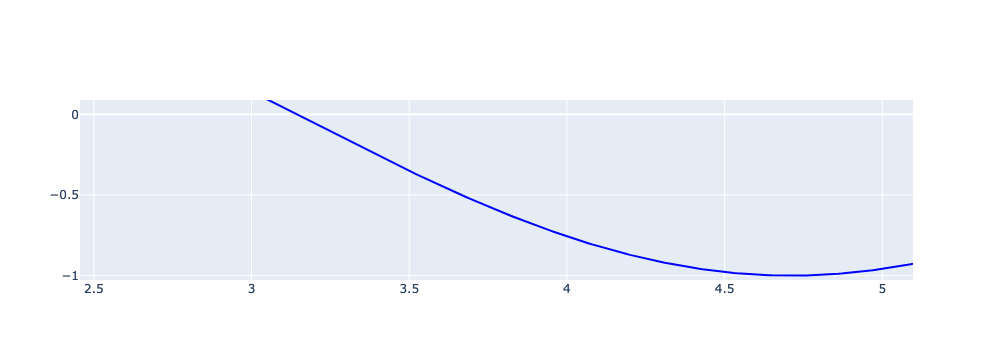

In [39]:
fig = make_subplots(rows=1, cols=1, column_widths= [2000], row_heights=[800])

for step in np.arange(0, 5, 0.1):
    fig.add_trace(
       go.Scatter(
          visible = False,
          line = dict(color = "blue", width = 2),
          name = "𝜈 = " + str(step),
          x = np.arange(0, 10, 0.01),
          y = np.sin(step * np.arange(0, 10, 0.01))
       )
    )
fig.data[10].visible=True

# Create and add slider
steps = []
for i in range(len(fig.data)):
    step = dict(
       method = "restyle",
       args = ["visible", [False] * len(fig.data)],
    )
step["args"][1][i] = True # Toggle i'th trace to "visible"
steps.append(step)
sliders = [dict(active = 10, steps = steps)]
fig.update_layout(sliders=sliders)
fig.show()

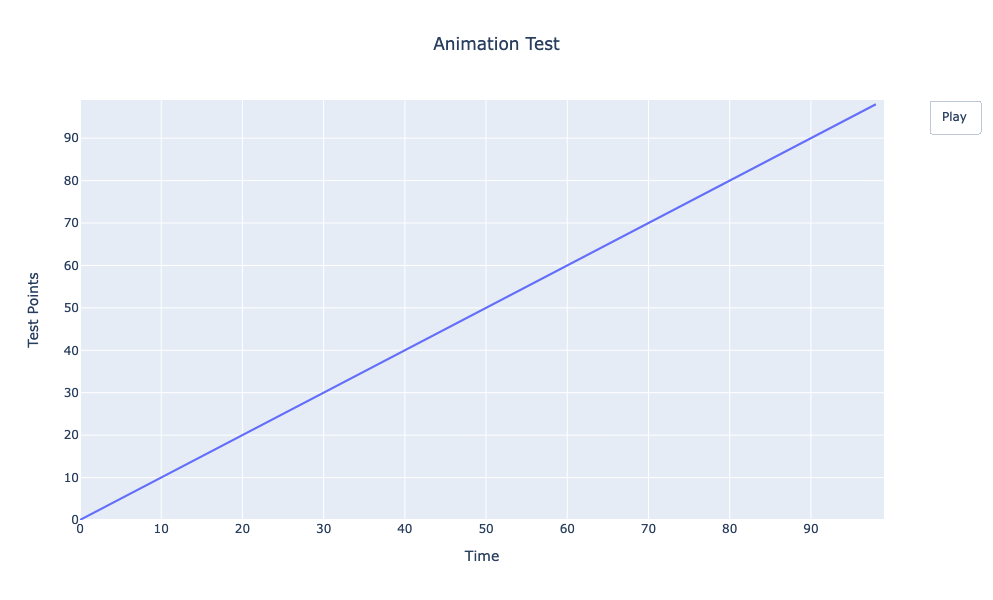

In [133]:
y=np.arange(100)     
fig=go.Figure(go.Scatter(y=y[:1], mode='lines', name='Testing Points'))
fig.update_layout(title='Animation Test',
                  title_x=0.5,
                  width=600, height=600, 
                  xaxis_title='Time', 
                  yaxis_title='Test Points',
                  yaxis_range=(0,99),
                  xaxis_range=(0,99), #you generate y-values for i =0, ...99, 
                                      #that are assigned, by default, to x-values 0, 1, ..., 99
                  
                  updatemenus=[dict(buttons = [dict(
                                               args = [None, {"frame": {"duration": 50, 
                                                                        "redraw": False},
                                                              "fromcurrent": True, 
                                                              "transition": {"duration": 0}}],
                                               label = "Play",
                                               method = "animate")],
                                type='buttons',
                                showactive=False,
                                y=1,
                                x=1.12,
                                xanchor='right',
                                yanchor='top')])
                                          
                    
frames= [go.Frame(data=[go.Scatter(y=y[:i])]) for i in range(1, 100)]
fig.update(frames=frames)

fig.show()